<h1><center>Task 4: Graph-based clustering algorithms</center></h1>

<h3>Introduction</h3>

In this notebook we present and compare different clustering algorithms based on PageRank. Clustering is a major building block of modern data analysis and is extensively used in important tasks in several fields ranging from statistics, computer science, and biology, to psychology and the social sciences. Clustering is the task of partitioning a set of collected data into disjoint subsets based on the underlying structure of the data. Cluster analysis itself is not one specific algorithm, but the general task to be solved: it can be achieved by various algorithms that differ significantly in their understanding of what constitutes a cluster and how to efficiently find them. \
In this work we consider networks represented by graphs and we choose the PageRank score as metric for labeling the nodes according to the cluster they belong to. \
In the first section we introduce the Authority-Shift algorithm and we show how it works on simple datasets; then we present the PageRank-Nibble approach and test it on the same simple points distributions. Finally, both algorithms are compared, on different and more complex datasets, with another widely used clustering approach for networks (Spectral Clustering) and with the ground truth.

In particular we focus on Authority-Shift clustering [1]  and PageRank-Nibble clustering [2].

[1] <i> Minsu Cho and Kyoung Mu Lee, "Authority-Shift Clustering: Hierarchical Clustering by Authority Seeking on Graphs", Proc. Computer Vision and Pattern Recognition (CVPR), 2010. </i> \
[2] <i> Andersen, Chung, Lang, "Local graph partitioning using pagerank vectors", 2006. </i>

In [1]:
#Import useful modules and packages
import numpy as np
import scipy as sp
import scipy.spatial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import csv
import cmath
import sklearn
from scipy.signal import find_peaks
from celluloid import Camera
import ffmpeg

In [2]:
import warnings
warnings.filterwarnings('ignore')

<h3> Authority-Shift Clusering </h3>

<b>Compute the affinity matrix and normalize it such that the sum for each column is equal to one.</b>

The matrix entry P<sub>ij</sub> can be interpreted to have the probability of transition from node j to i.


In [3]:
def computeAffinityMatrix(data, scale=None, order=None):
    # Input: 
    #    - data: matrix of points. Each row corresponds to the coordinates of a point.
    # 
    # Output: 
    #    - Prw: Affinity matrix W as a pair-wise data similarity matrix.
    #      Similarity is computed by considering euclidean distance between each pair of points.
                
    
    #Condensed distance matrix between points
    distances = sp.spatial.distance.pdist(data)
    
    #Converts between condensed distance matrices and square distance matrices
    distances = sp.spatial.distance.squareform(distances)
    
    if scale is None:
        scale = 0.05 * np.max(distances)

    if order is None:
        order = 2
        
    W = np.exp(-(distances/scale)**order);
    
    # Normalization

    nPoints = W.shape[0]
    
    # column-stochastic matrix
    Prw = W;
    for i in range(nPoints):
        Prw[i,i] = 0
        
    D = np.diag(np.sum(W, axis=0))
    
    Prw = np.matmul(Prw, np.linalg.inv(D))
    
    return Prw

This function computes the Personalized PageRank matrix, whose i<sup>th</sup> column is PPR(i). PPR(i) is the individual PPR vector of node i which measures how important each node is in relation to node i. This matrix is the same we presented in the previous notebook (matrix L), computed in a slightly different way to account for the fact that, for the sake of visualization, we are not considering an actual network but points on a plane, from which we create a graph.
    



In [4]:
def computePPRmatrix(Prw, c):
    # Input: 
    #    - Prw: Column stochastic matrix representing a graph
    #    - c: Damping factor. It weights between walk & jump.
    # 
    # Output: 
    #    - W_PPR: Personalized PageRank Matrix
    
    nSize = Prw.shape[0]
    
    # make personalization matrix
    M_pers = sp.sparse.eye(nSize)
    
    # nSize by nSeed
    W_PPR = np.linalg.inv(M_pers - c*Prw) * (1-c)
    
    # Bias substraction
    W_PPR = W_PPR - (M_pers * (1-c))
    
    # Normalization
    normM = np.zeros(W_PPR.shape)
    np.fill_diagonal(normM, 1 / W_PPR.sum(axis=0))
    W_PPR = np.matmul(W_PPR,normM)
    
    return W_PPR

<b>We label each node with its authority sink. The authority sinks determine the cluster membership for nodes and the total number of emergent clusters.</b>
    
The set of minimal self-authoritative clusters is obtained by shifting each node towards its authority node. The shift evolves the trajectory of the node i following the authority nodes until it reaches the convergent node or find a cycle in the shifting sequence, referred to as the authority sink.


In [5]:
def find_sink(shifted_idx):
    # Input: 
    #    - shifted_idx: shifted indexes
    # 
    # Output: 
    #    - sinkIdx: sink indexes
    
    sinkIdx = np.zeros(shifted_idx.shape[0], dtype=int)  
    nNode = len(shifted_idx)
    
    # Traverse for each node
    for i in range(nNode):
        sinkIdx = find_sink_recur(i, shifted_idx, sinkIdx)
    
    return sinkIdx

def find_sink_recur(cur_idx, shifted_idx, sinkIdx):

    # if a sink
    if cur_idx == shifted_idx[cur_idx]:
        
        sinkIdx[cur_idx] = cur_idx
        
    else:
        
        # if not labelled, dive into recursion
        if sinkIdx[shifted_idx[cur_idx]] == 0:
            
            # footmark for a cyclic sink
            sinkIdx[cur_idx] = cur_idx
            sinkIdx = find_sink_recur(shifted_idx[cur_idx], shifted_idx, sinkIdx)
        
        # inherit the sink label
        sinkIdx[cur_idx] = sinkIdx[shifted_idx[cur_idx]]
        
    return sinkIdx      

<b>Authority-Shift clustering algorithm.</b>


This clustering method has been presented in: \
<i>Minsu Cho and Kyoung Mu Lee, \
Authority-Shift Clustering: \
Hierarchical Clustering by Authority Seeking on Graphs, \
Proc. Computer Vision and Pattern Recognition (CVPR), 2010. </i>

In [6]:
def authorityShift(points, Prw, c, k, itermax):
    # Input: 
    #    - points: Matrix of points. Each row corresponds to the coordinates of a point.
    #    - Prw: Column stochastic matrix representing a graph.
    #    - c: Damping factor. It weights between walk & jump.
    #    - k: Number of clusters.
    #    - itermax: Maximum propagation order for PPR.
    # 
    # Output: 
    #    - authIdx_all: list of authority node indexes for each node of the graph.
    
    W_PPR_initial = computePPRmatrix(Prw, c)
    
    #  initiaization for authority-shift
    W_PPR_reduced = np.array(W_PPR_initial)                 # initial PPRs for the current layer
    W_PPR_nOrder = np.array(W_PPR_initial)                  # nth order PPRs in the current layer
    
    nSize = Prw.shape[0]
    
    authIdx = np.array([i for i in range(nSize)])           # current index set of authority nodes (super nodes)
    szOfAuthIdx = np.array([1 for i in range(nSize)])       # member size for each super node
    authIdx_all = np.array([i for i in range(nSize)])       # current authority index for each initial node
    nPPROrder = 1                                           # PPR order for the current layer

    for kIter in range(itermax):
        
        # authority-shifting: where is my authority node?
        # finding the maximum along each column is equal to forward propagation
        shiftVal = (np.amax(W_PPR_nOrder, axis=0)).flatten()
        elementIdx = (np.argmax(W_PPR_nOrder, axis=0)).flatten()
        
        # find authority-sink for each node
        sink_elementIdx = find_sink(elementIdx)
        final_authIdx = np.array([authIdx[i] for i in sink_elementIdx])
        
        shifted_idx = np.nonzero([final_authIdx != authIdx])[1]
        new_seedList = np.unique(final_authIdx)   # np.unique returns an array already sorted 
        
        if len(shifted_idx) == 0:
            
            # PPR propagation for n-th order PPR
            W_PPR_nOrder = np.matmul(W_PPR_reduced,W_PPR_nOrder) 
            nPPROrder = nPPROrder + 1
            
        else:
        
            # supernode aggregation and matrix reduction
            for cIdx in shifted_idx:
                authIdx_all[authIdx_all == authIdx[cIdx]] = final_authIdx[cIdx]
                    
            # start updating W_PPR_reduced
            tmp_W_PPR_reduced = np.zeros((len(authIdx),len(new_seedList)))
            new_szOfAuthIdx = np.zeros(len(new_seedList), dtype=int)
            
            # First, row-wise summation considering sizes of supernodes
            for jIter in range(len(new_seedList)):

                tmp_seedListIdx = np.nonzero(final_authIdx == new_seedList[jIter])[0]
                new_szOfAuthIdx[jIter] = np.sum([szOfAuthIdx[i] for i in tmp_seedListIdx])
                
                if len(tmp_seedListIdx) > 1:
                    # more than one index has been shifted
                    tmp_Norm = np.diag(szOfAuthIdx[tmp_seedListIdx]) / new_szOfAuthIdx[jIter]
                    tmp_W_PPR_reduced[:,jIter] = np.sum(np.matmul(W_PPR_reduced[:,tmp_seedListIdx], tmp_Norm), axis=1)
                    
                else:
                    # only one element has been shifted
                    tmp_W_PPR_reduced[:,jIter] = W_PPR_reduced[:,tmp_seedListIdx[0]]    # accessed with 0 index
                    
            
            # Second, column-wise summation
            new_W_PPR_reduced = np.zeros((len(new_seedList),len(new_seedList)))
            
            for jIter in range(len(new_seedList)):

                tmp_seedListIdx = np.nonzero(final_authIdx == new_seedList[jIter])[0]
                new_W_PPR_reduced[jIter,:] = np.sum(tmp_W_PPR_reduced[tmp_seedListIdx,:] , axis=0)
             
            # Assignment for next iteration
            W_PPR_reduced = new_W_PPR_reduced
            W_PPR_nOrder = new_W_PPR_reduced
            seedList = new_seedList
            authIdx = new_seedList
            szOfAuthIdx = new_szOfAuthIdx
            
            # reset the PPR order
            nPPROrder = 1;
            
        # stop if the number of cluster is equal to or less then k 
        if len(authIdx) <= k:
            break
    
    # return the final result
    return authIdx_all

<b>Display an animation showing how the Authority-Shift algorithm assigns the authority nodes at each iteration.</b>

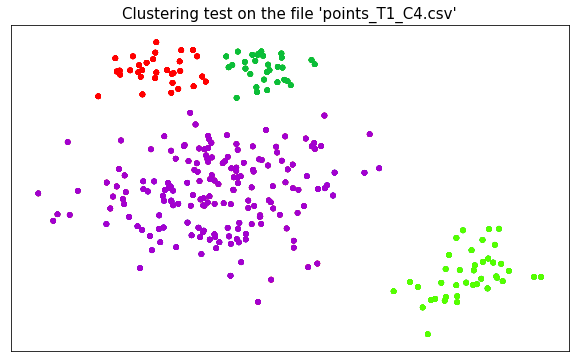

In [7]:
#Import one of the datasets
fname = 'points_T1_C4.csv'
ncl = 4

reader = csv.reader(open('data/simple_clusters/'+fname), delimiter=",")
pointsList = list(reader)
points = np.array(pointsList).astype("float")

#Prepare Authority-Shift
Prw =  computeAffinityMatrix(points)

#Initialize the figure and the Camera object for the animation
fig, ax = plt.subplots(1,1,figsize=(10,6));
camera = Camera(fig);

#Run Authority-Shift and create animation
for i in range(1,15):
    authorityshift_c = 0.85
    itermax = i

    tags = authorityShift(points, Prw, authorityshift_c, ncl, itermax)

    label=np.array(tags)
    pointsLabelled = np.zeros((points.shape[0], points.shape[1] + 1))
    pointsLabelled[:,0:2]=points
    pointsLabelled[:,2]=label

    dfLabelledPoints = pd.DataFrame(pointsLabelled, columns=['x', 'y','Category'])

    # Print data clusters
    dfLabelledPoints.plot.scatter('x', 'y',  c='Category', cmap='prism', colorbar=False, ax = ax, subplots=True);
    ax.set_title("Clustering test on the file '{}'".format(fname), fontsize=15);
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    camera.snap();

In [8]:
from IPython.display import HTML

animation = camera.animate(interval=500, repeat = True, repeat_delay = 1000);
HTML(animation.to_html5_video())

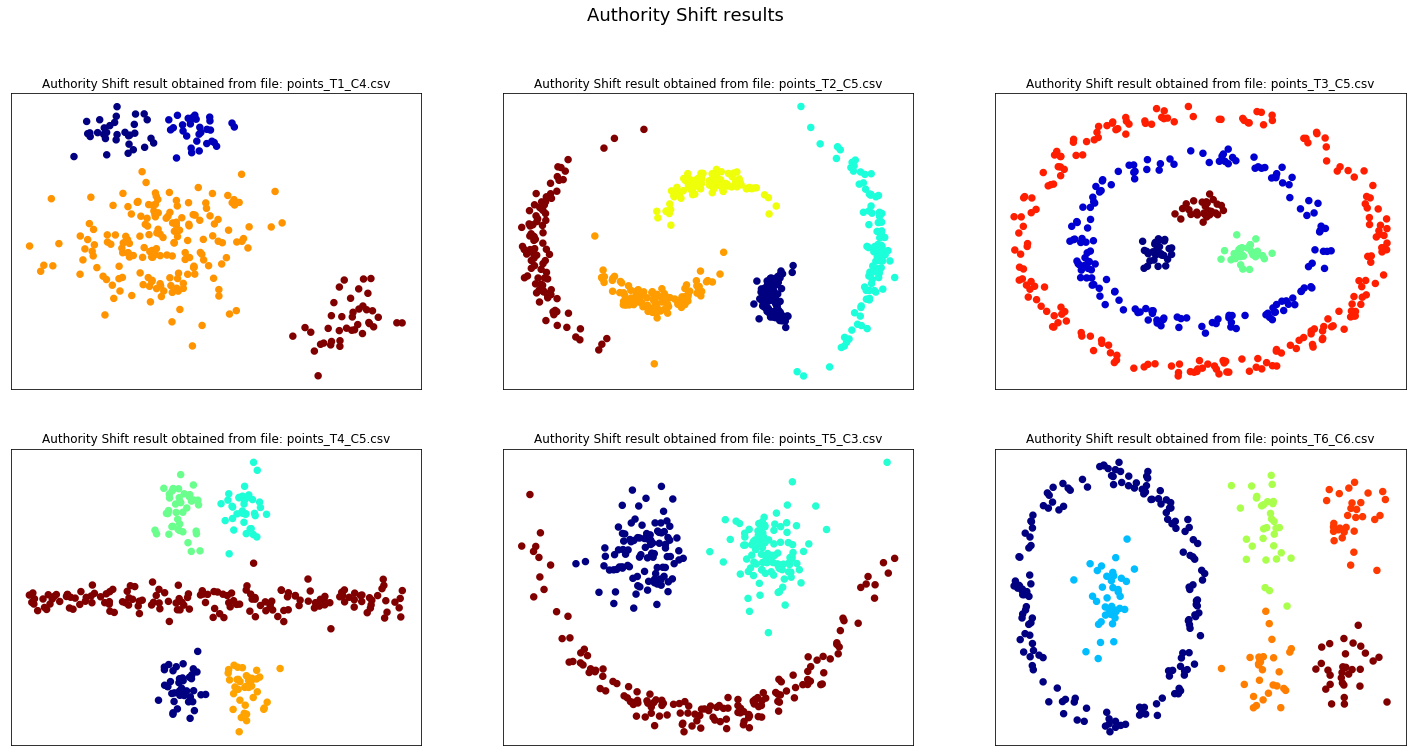

In [9]:
import os

directory = 'data/simple_clusters/'
files = [f for f in os.listdir(directory) if f.endswith(".csv")]

# Parameters for the Authority shift algorithm
authorityshift_c = 0.85
itermax = 1000

fig, ax = plt.subplots(2,3, figsize=(25,12))

for c, file_name in enumerate(files):
    
    # Extract the number of clusters k from the file name
    start = file_name.find('_C') + 2
    end = file_name.find('.csv')
    k = int(file_name[start:end])

    file = csv.reader(open(directory+file_name), delimiter=',')
    points = np.array(list(file), dtype='float')

    Prw =  computeAffinityMatrix(points)
    
    labels = authorityShift(points, Prw, authorityshift_c, k, itermax)
    
    labeled_points = np.zeros((points.shape[0], points.shape[1] + 1))
    labeled_points[:, 0:2] = points
    labeled_points[:, 2] = labels
    
    data = pd.DataFrame(labeled_points, columns=['x', 'y','label']);
    
    if c < 3:
        data.plot.scatter('x', 'y',  c='label', cmap='jet', linewidths=3, colorbar=False, ax = ax[0,c], subplots=True)
        tit = "Authority Shift result obtained from file: " + str(file_name) 
        ax[0,c].set_title(tit)
        ax[0,c].get_yaxis().set_visible(False)
        ax[0,c].get_xaxis().set_visible(False)
    else:
        data.plot.scatter('x', 'y',  c='label', cmap='jet', linewidths=3, colorbar=False, ax = ax[1,c-3], subplots=True)
        tit = "Authority Shift result obtained from file: " + str(file_name) 
        ax[1,c-3].set_title(tit)
        ax[1,c-3].get_yaxis().set_visible(False)
        ax[1,c-3].get_xaxis().set_visible(False)
    
plt.suptitle("Authority Shift results", fontsize=18)    
plt.show()

<h3>PageRank-Nibble Clustering Algorithm</h3>

This function computes the conductance $\phi(S) = \frac{cut(S, S^C)}{min(assoc(S), assoc(S^C)}$ of the nodes of the network, this metric is needed in order to find the optimal cuts, that corresponds the local minima in it. This happens because a minimum means that there are many edges inside the found cluster and just a few pointing outside it. It takes as input the adjacency matrix of the network.

In [10]:
def conductance_sweep(A):
    # Input:
    #   - A: adjacency matrix
    #
    # Output:
    #   - conduct: a 1D vector with the values of the conductance for each node
    #
    a = np.sum(np.triu(A), axis=0)
    b = np.sum(np.tril(A), axis=0)
    D = np.sum(a+b)
    assoc = np.cumsum(a+b)
    assoc = [min(a, D - a) for a in assoc]
    cut = np.cumsum(b-a)
    conduct = cut/assoc
    conduct = conduct[0:-1]
    return conduct

This function computes the minima of the conductance, to be used to apply optimal cuts and split the network into communities. If k clusters are needed, the function return k - 1 minima.

In [11]:
def find_minima(conduct, k):
    # Input:
    #   - conduct: 1D vector with the conductance value of each node
    #   - k: number of clusters
    #
    # Output:
    #   - minima: the k - 1 minima of the conductance
    #

    #Invert the conductance (the following function finds peaks, not minima)
    conduct = 1  - conduct

    #if 10 or more cluster are needed, the minimum distance between two peaks is reduced in order to be sure to have enough minima
    if k > 9:
        minima, prop = find_peaks(conduct, distance = 5, height=0.5)
    else:
        minima, prop = find_peaks(conduct, distance = 30, height=0.5)
    
    #Sort the found peaks by decreasing height
    he = prop['peak_heights']
    d = dict(zip(minima, he))
    d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}
    minima = list(d.keys())[::-1]

    #Take the k - 1 highest peaks, returning the indexes of the corresponding nodes in increasing order
    minima = sorted(minima[:k-1])
    
    return minima

The following is the actual clustering function. It takes as input the 2D array with the coordinates of the points, the damping factor of the PageRank algorithm (alpha) and the number of clusters to be found (k). Firstly the adjacency matrix is extracted from the points distribution, considering two points as two linked nodes if their distance is less than 4. Then the Personalized PageRank of the network (with the node 1 as seed, set to 1 in the teleport vector) is computed and its scores are sorted in a decreasing way. This sorting operation determines a permutation of the adjacency matrix, which is used to compute the conductance; indeed these scores measures the similarity of the nodes with the seed, so nodes with a low score are likely to belong to a different cluster. This is exploited to detect the minima of $\phi$ and find where to apply the cuts to optimally divide the clusters (communities). Finally the points are labeled according to the cluster they are found to belong to.

In [12]:
def PageRankNibble(points, alpha, k):
    # Input:
    #   - points: 2D array with the coordinates of the points to be clustered
    #   - alpha: damping factor of the ApproximatePageRank algorithm
    #   - k: number of clusters
    #
    # Output:
    #   - labels: array with the labels of each node, to assign it to its cluster
    #   - conduct: 1D array with the conductance
    #   - mins: 1D array with the minima
    #   - Ap_ap: the adjacency matrix reorganized according to the detected communities
    #

    #Points as complex numbers
    re = points[:,0]
    im = points[:,1]
    v = np.array([complex(re[i], im[i]) for i in range(len(re))])

    #Extract adjacency matrix (a point is considered linked to another of the distance between them is less than 4)
    A = 1*(abs(v[:, np.newaxis] - v)<=4)
    A = A - np.diag(np.diag(A))
    N = A.shape[0]
    G = nx.from_numpy_matrix(A)

    #Compute the Pagerank
    r2 = np.array(list(nx.pagerank(G, alpha=alpha, personalization={1:1})))

    #Conductance sweep
    #Sort by decreasing pagerank values
    nodes = np.flip(np.argsort(r2))
    values = np.flip(np.sort(r2))

    #Number of nodes with non-zero value
    Nmax = np.argwhere(values>0)[-1].squeeze()
    #Permutate the adjacency matrix according to the new order of the nodes
    Ap_ap = np.zeros((N,N))
    for x,i in enumerate(nodes):
        for y,j in enumerate(nodes):
            Ap_ap[x,y] = A[i,j]

    #Compute the conductance and take only the significant values
    conduct = conductance_sweep(Ap_ap)
    conduct = conduct[0:Nmax]

    #Find minima (optimal cuts)
    mins = find_minima(conduct, k)
    cuts = [0]
    for m in mins:
        cuts.append(m+1) #add 1 to the minimum in order to include it in the cluster

    #If the conductance does not allow too detect enough minima, reduce the numer of clusters to the maximum possible
    if(len(mins) < k-1):
        k = len(mins)
    
    #Communities detection
    C = []
    for cl in range(k-1):
        C.append(nodes[cuts[cl]:cuts[cl+1]])
    C.append(nodes[cuts[-1]:])

    #Labels assignment
    labels = np.zeros(N)
    for i, c in enumerate(C):
        labels[c] = i

    return labels, conduct, mins, Ap_ap

Here we apply the PageRank-Nibble clusering to a simple dataset, in order to show it works. The conductance (with its minima) and the rearranged adjacency matrix are also diplayed.

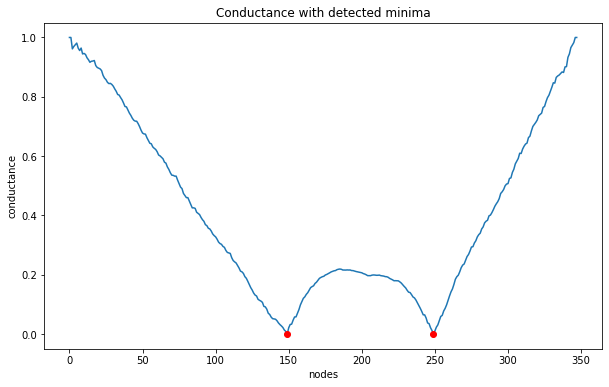

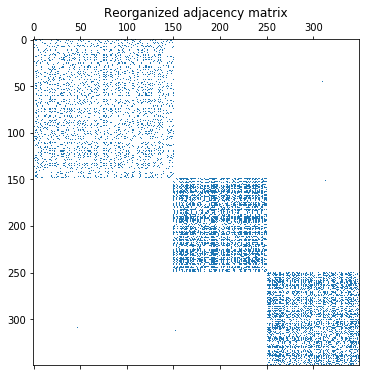

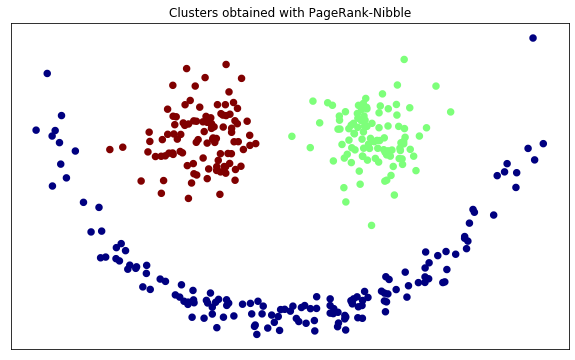

In [13]:
#Import one of the daatsets
fpath = 'data/simple_clusters/points_T5_C3.csv'
ncl = 3

dataset = pd.read_csv(fpath, header=None)
x = dataset[0]
y = dataset[1]
points = np.zeros((len(dataset), 2))
points[:, 0] = x
points[:, 1] = y

#Run PageRank-Nibble
[lab, cond, mins, a] = PageRankNibble(points, alpha=0.85, k=ncl)

#Plot the conductance together with minima
plt.figure(figsize=(10,6))
plt.plot(cond)
for m in mins:
    plt.plot(m, cond[m], 'ro')
plt.title('Conductance with detected minima')
plt.xlabel('nodes')
plt.ylabel('conductance')
plt.show()

#Plot the reorganized adjacency matrix
plt.figure(figsize=(10,6))
plt.spy(a, marker=',')
plt.title('Reorganized adjacency matrix')
plt.show()

#Plot the obtained clusters
points = np.zeros((len(dataset), 3))
points[:, 0] = dataset[0]
points[:, 1] = dataset[1]
points[:, 2] = lab

data = pd.DataFrame(points, columns=['x', 'y', 'label'])

fig, ax = plt.subplots(1,1, figsize = (10,6))
data.plot.scatter('x', 'y',  c='label', cmap='jet', linewidths=3, colorbar=False, ax=ax)
ax.set_title('Clusters obtained with PageRank-Nibble')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.show()



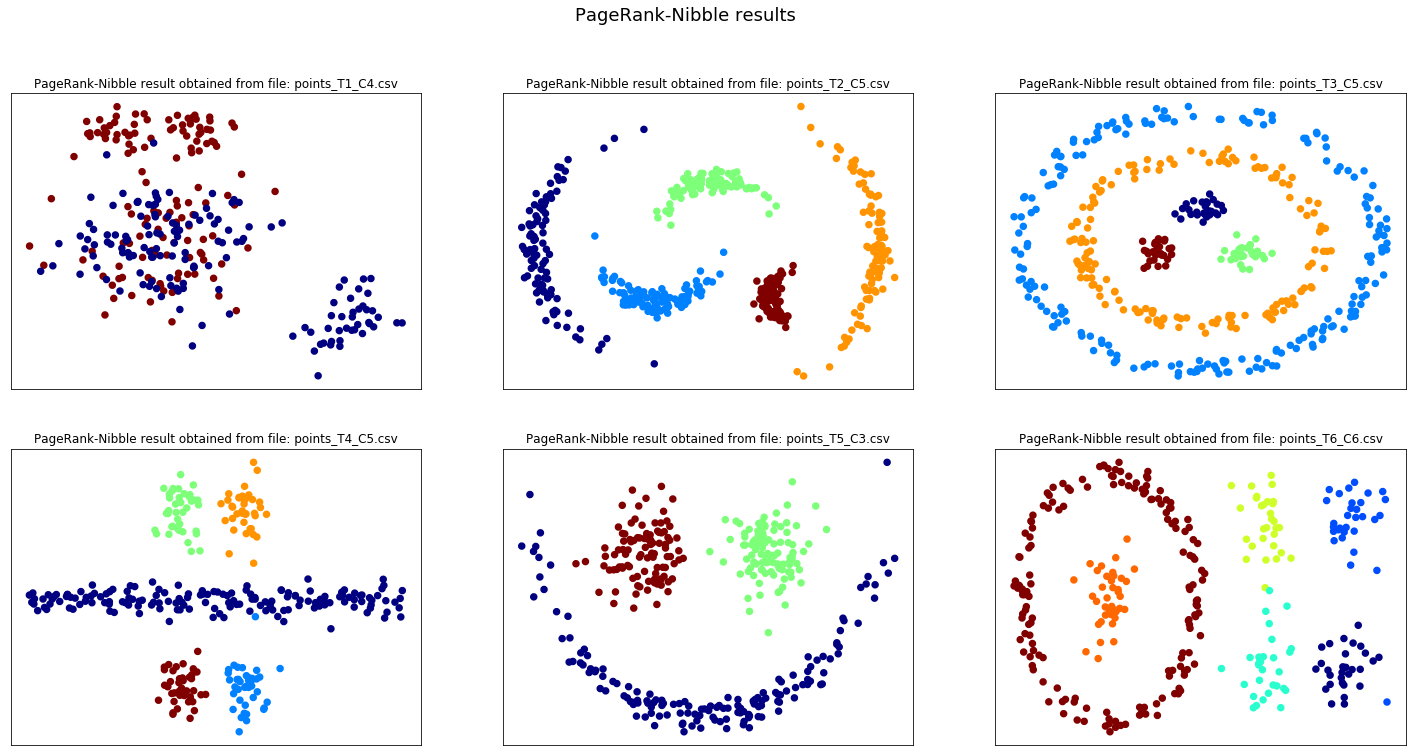

In [14]:
import os

directory = 'data/simple_clusters/'
files = [f for f in os.listdir(directory) if f.endswith(".csv")]

# Parameter for the PageRankNibble
alpha = 0.85

fig, ax = plt.subplots(2,3, figsize=(25,12))

for c, file_name in enumerate(files):
    
    # Extract the number of clusters k from the file name
    start = file_name.find('_C') + 2
    end = file_name.find('.csv')
    k = int(file_name[start:end])

    file = csv.reader(open(directory+file_name), delimiter=',')
    points = np.array(list(file), dtype='float')
    
    [labels, _, _, _] = PageRankNibble(points, alpha, k)
    
    labeled_points = np.zeros((points.shape[0], points.shape[1] + 1))
    labeled_points[:, 0:2] = points
    labeled_points[:, 2] = labels
    
    data = pd.DataFrame(labeled_points, columns=['x', 'y','label']);
    
    if c < 3:
        data.plot.scatter('x', 'y',  c='label', cmap='jet', linewidths=3, colorbar=False, ax = ax[0,c], subplots=True)
        tit = "PageRank-Nibble result obtained from file: " + str(file_name) 
        ax[0,c].set_title(tit)
        ax[0,c].get_yaxis().set_visible(False)
        ax[0,c].get_xaxis().set_visible(False)
    else:
        data.plot.scatter('x', 'y',  c='label', cmap='jet', linewidths=3, colorbar=False, ax = ax[1,c-3], subplots=True)
        tit = "PageRank-Nibble result obtained from file: " + str(file_name) 
        ax[1,c-3].set_title(tit)
        ax[1,c-3].get_yaxis().set_visible(False)
        ax[1,c-3].get_xaxis().set_visible(False)
    
plt.suptitle("PageRank-Nibble results", fontsize=18)    
plt.show()

<h3>Performance comparison</h3>

<b>Maps the labels obtained by clustering algorithms to the groundtruth labels used in the dataset.</b> 

This is useful for performance comparison of clustering algorithms.

In [15]:
import operator

def map_labels(true_labels, labels):
    # Input: 
    #    - true_labels: groundtruth labels used in the dataset.
    #    - labels: labels obtained by clustering algorithms.
    # 
    # Output: 
    #    - labels: labels obtained by clustering algorithms mapped to the same values of true_labels
        
    true_indexes = np.unique(true_labels)
    indexes = np.unique(labels)
    
    # Dictionaries where we count correspondences between indexes
    # Backward: from auth labels to true labels
    
    b_matrix = {i : {ti : 0 for ti in true_indexes} for i in indexes}
    
    for i in range(labels.shape[0]):
        b_matrix[labels[i]][true_labels[i]] += 1
    
    b_mapping = {i : 0 for i in indexes}
    for i in b_matrix:
        b_mapping[i] = max(b_matrix[i].items(), key=operator.itemgetter(1))[0]
 
    for i in range(labels.shape[0]):
        labels[i] = b_mapping[labels[i]]
        
    return labels        

Qui mettere commenti sui risultati del confronto, spiegando perchè

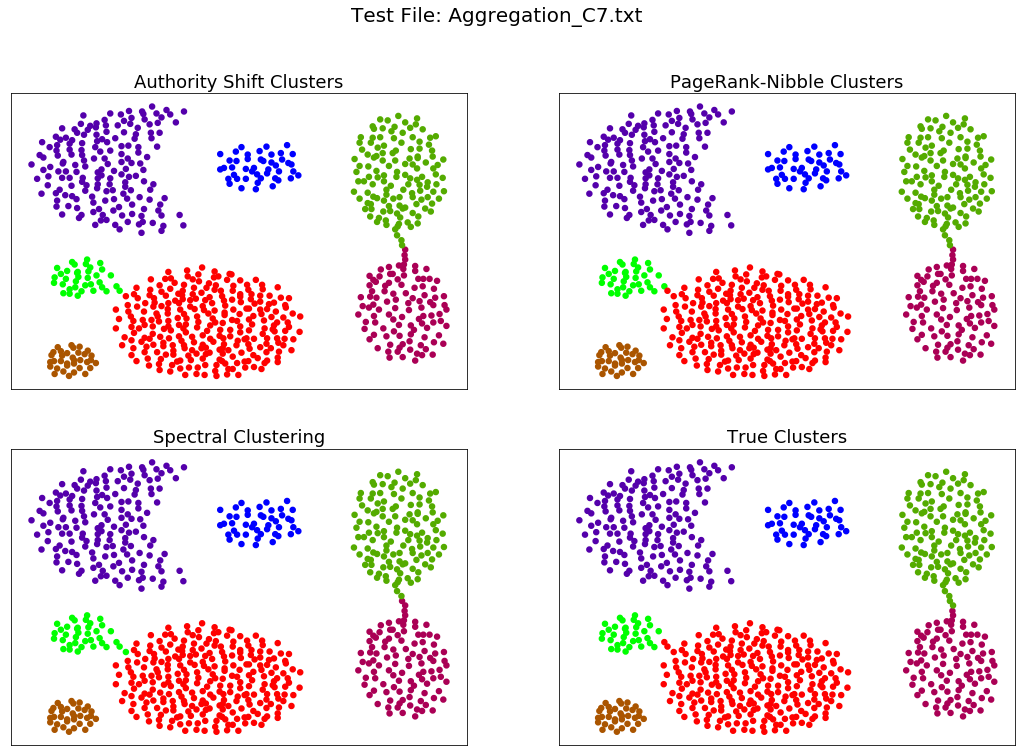

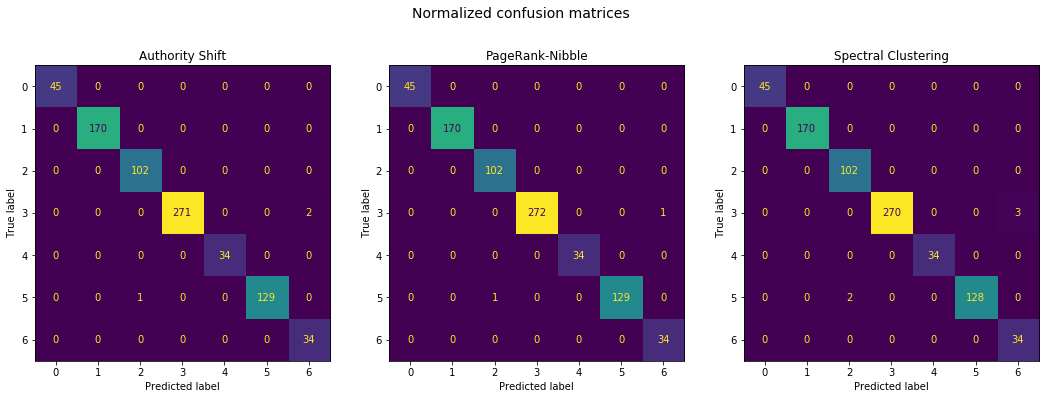

+---------------------+----------------------+--------------------+------------+-------------------------------+------------+
|      Algorithm      | Correctly classified | Wrongly classified | Error rate | Normalized Mutual Information | Rand index |
+---------------------+----------------------+--------------------+------------+-------------------------------+------------+
|   Authority Shift   |         785          |         3          |   0.40 %   |             0.988             |   0.997    |
|   PageRank-Nibble   |         786          |         2          |   0.30 %   |             0.992             |   0.998    |
| Spectral Clustering |         783          |         5          |   0.60 %   |             0.982             |   0.996    |
+---------------------+----------------------+--------------------+------------+-------------------------------+------------+


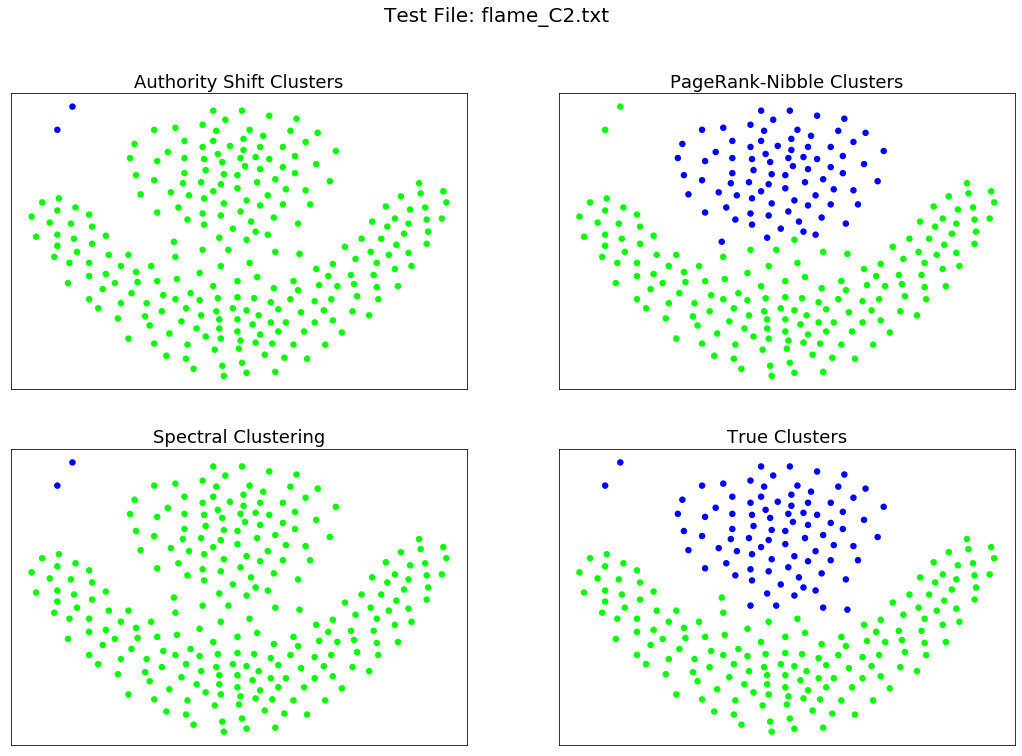

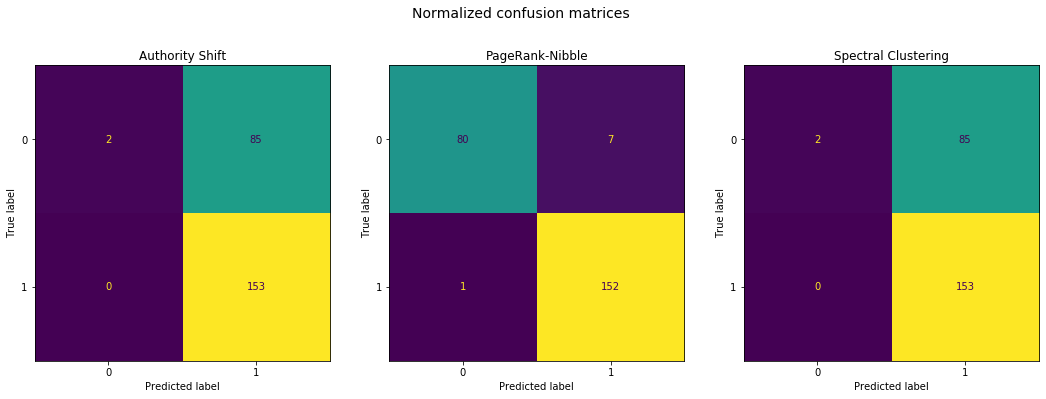

+---------------------+----------------------+--------------------+------------+-------------------------------+------------+
|      Algorithm      | Correctly classified | Wrongly classified | Error rate | Normalized Mutual Information | Rand index |
+---------------------+----------------------+--------------------+------------+-------------------------------+------------+
|   Authority Shift   |         155          |         85         |  35.40 %   |             0.024             |   0.541    |
|   PageRank-Nibble   |         232          |         8          |   3.30 %   |             0.792             |   0.935    |
| Spectral Clustering |         155          |         85         |  35.40 %   |             0.024             |   0.541    |
+---------------------+----------------------+--------------------+------------+-------------------------------+------------+


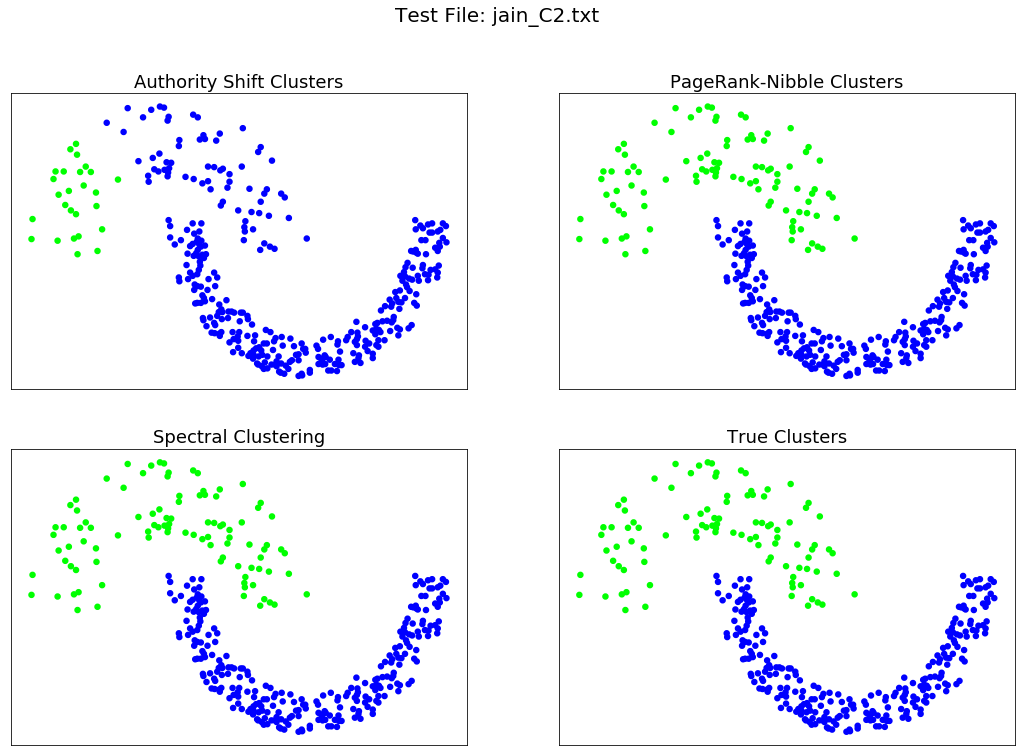

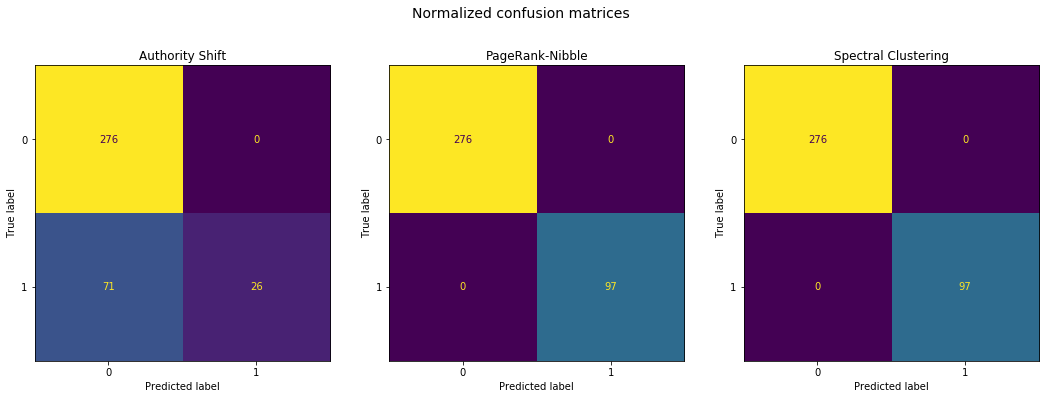

+---------------------+----------------------+--------------------+------------+-------------------------------+------------+
|      Algorithm      | Correctly classified | Wrongly classified | Error rate | Normalized Mutual Information | Rand index |
+---------------------+----------------------+--------------------+------------+-------------------------------+------------+
|   Authority Shift   |         302          |         71         |  19.00 %   |             0.246             |   0.691    |
|   PageRank-Nibble   |         373          |         0          |   0.00 %   |              1.0              |    1.0     |
| Spectral Clustering |         373          |         0          |   0.00 %   |              1.0              |    1.0     |
+---------------------+----------------------+--------------------+------------+-------------------------------+------------+


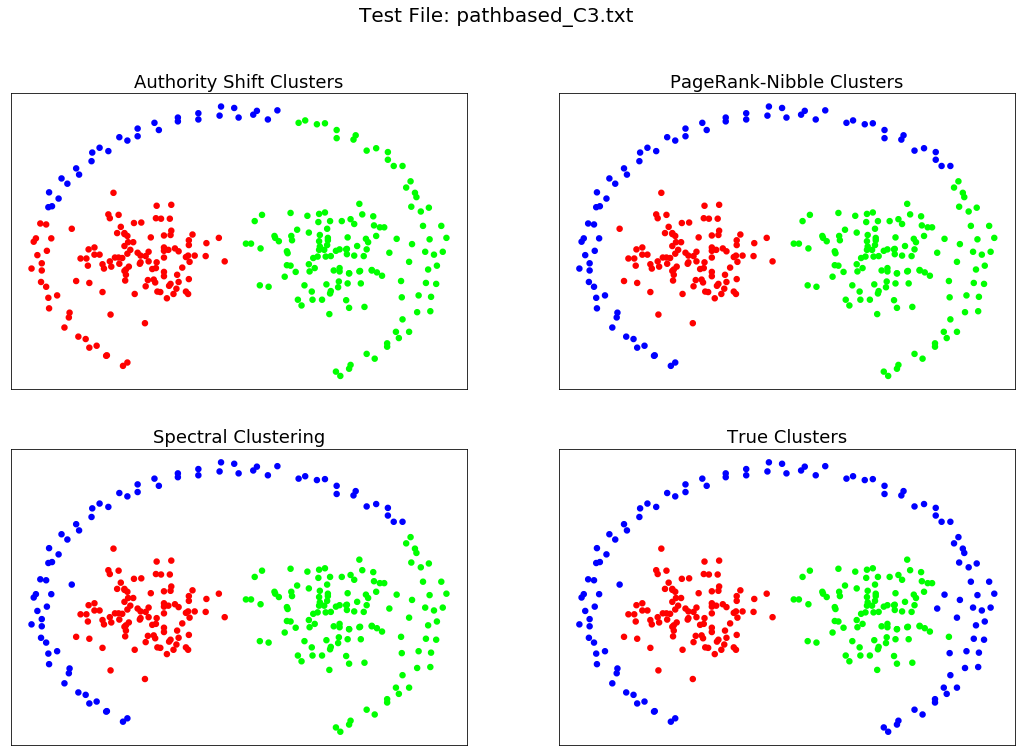

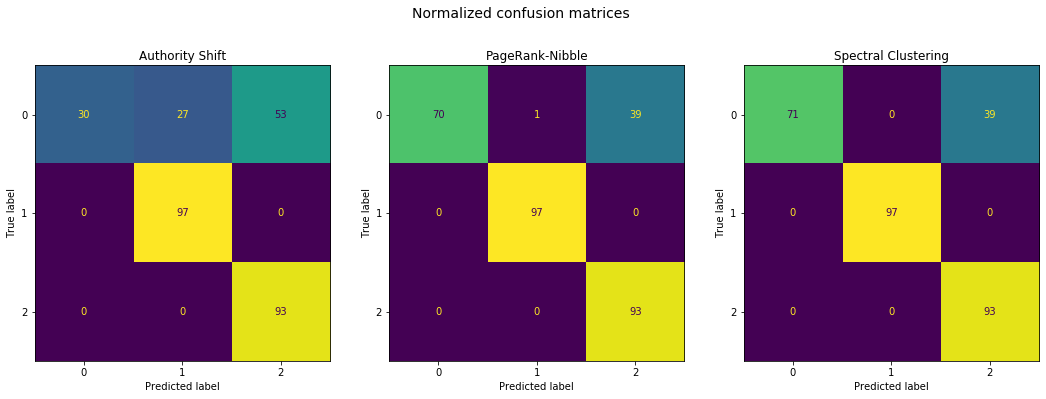

+---------------------+----------------------+--------------------+------------+-------------------------------+------------+
|      Algorithm      | Correctly classified | Wrongly classified | Error rate | Normalized Mutual Information | Rand index |
+---------------------+----------------------+--------------------+------------+-------------------------------+------------+
|   Authority Shift   |         220          |         80         |  26.70 %   |             0.549             |   0.746    |
|   PageRank-Nibble   |         260          |         40         |  13.30 %   |              0.75             |   0.854    |
| Spectral Clustering |         261          |         39         |  13.00 %   |             0.766             |   0.857    |
+---------------------+----------------------+--------------------+------------+-------------------------------+------------+


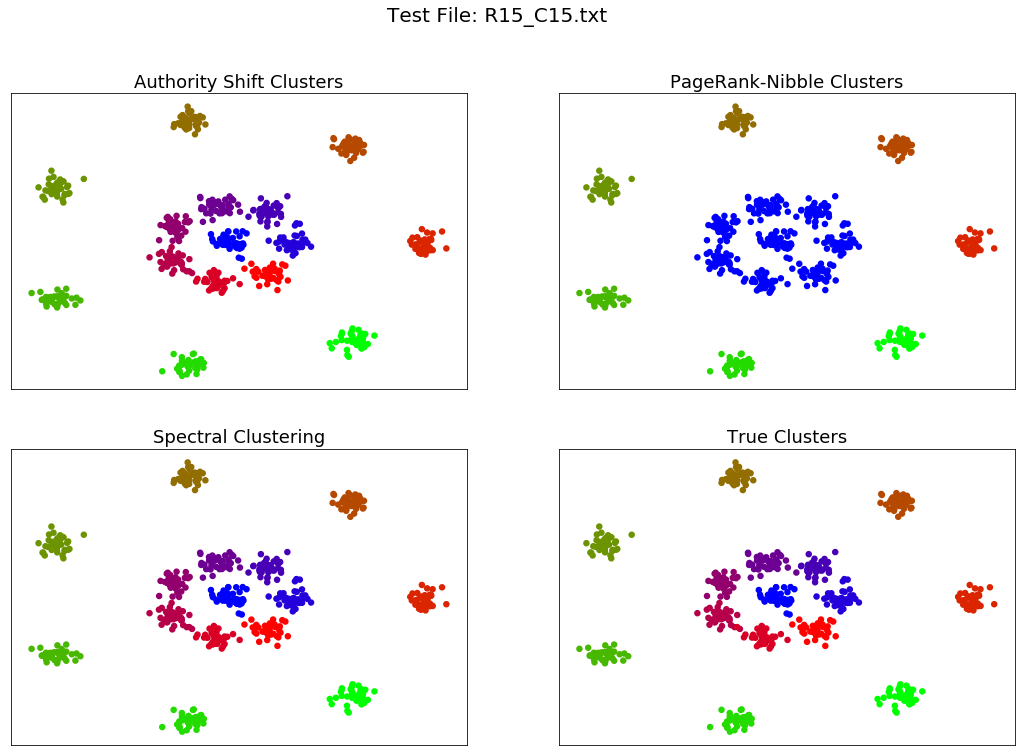

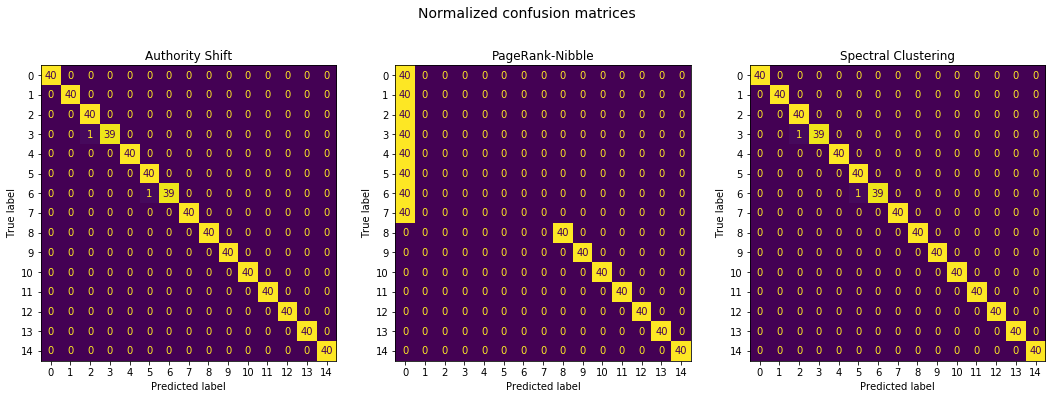

+---------------------+----------------------+--------------------+------------+-------------------------------+------------+
|      Algorithm      | Correctly classified | Wrongly classified | Error rate | Normalized Mutual Information | Rand index |
+---------------------+----------------------+--------------------+------------+-------------------------------+------------+
|   Authority Shift   |         598          |         2          |   0.30 %   |             0.994             |   0.999    |
|   PageRank-Nibble   |         320          |        280         |  46.70 %   |             0.743             |   0.751    |
| Spectral Clustering |         598          |         2          |   0.30 %   |             0.994             |   0.999    |
+---------------------+----------------------+--------------------+------------+-------------------------------+------------+


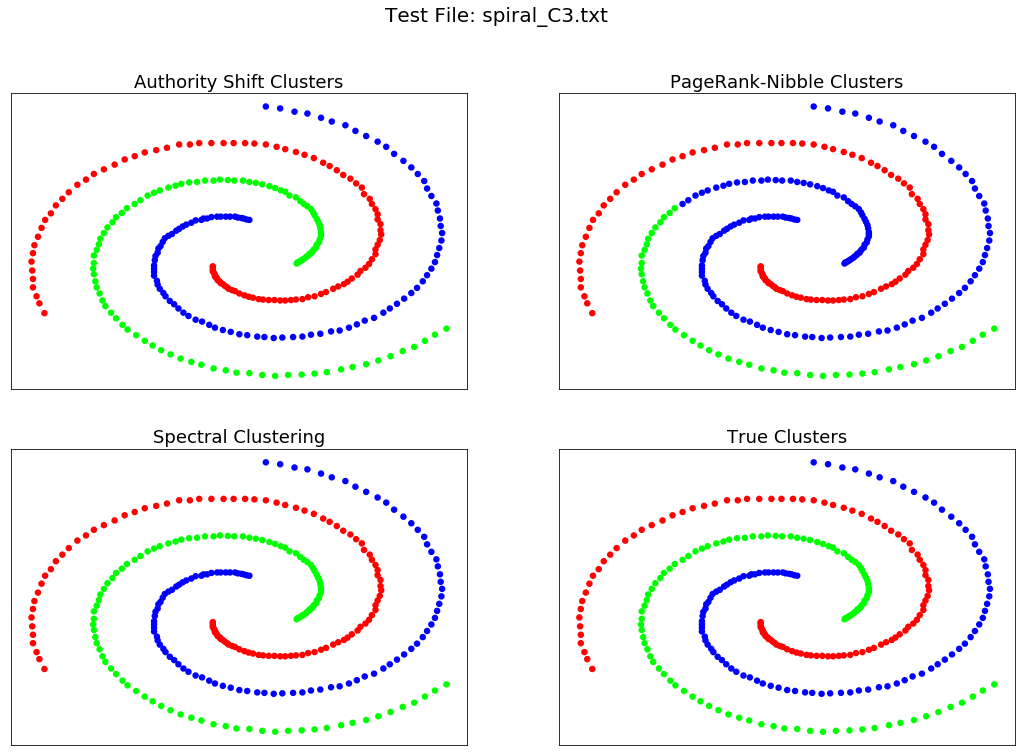

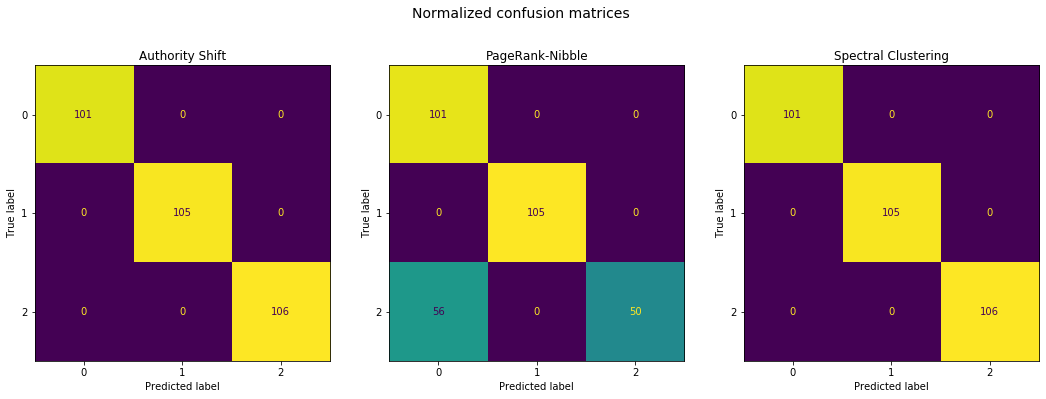

+---------------------+----------------------+--------------------+------------+-------------------------------+------------+
|      Algorithm      | Correctly classified | Wrongly classified | Error rate | Normalized Mutual Information | Rand index |
+---------------------+----------------------+--------------------+------------+-------------------------------+------------+
|   Authority Shift   |         312          |         0          |   0.00 %   |              1.0              |    1.0     |
|   PageRank-Nibble   |         256          |         56         |  17.90 %   |             0.733             |   0.826    |
| Spectral Clustering |         312          |         0          |   0.00 %   |              1.0              |    1.0     |
+---------------------+----------------------+--------------------+------------+-------------------------------+------------+


In [16]:
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import SpectralClustering
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import rand_score
from prettytable import PrettyTable

directory = 'data/test_clusters/'
files = [f for f in os.listdir(directory) if f.endswith(".txt")]

# Parameters for the Authority shift algorithm
authorityshift_c = 0.85
itermax = 1000

#Parameters for the PageRank-Nibble 
alpha = 0.85


for file_name in files:
    
    # Extract the number of clusters k from the file name
    start = file_name.find('_C') + 2
    end = file_name.find('.txt')
    k = int(file_name[start:end])

    file = csv.reader(open(directory+file_name), delimiter='\t')
    labeled_points = np.array(list(file), dtype='float')
    
    points = labeled_points[:, 0:2]
    true_labels = (labeled_points[:, 2]).astype(int)
    
    #Athority Shift
    Prw =  computeAffinityMatrix(points)
    labels_aut = authorityShift(points, Prw, authorityshift_c, k, itermax)
    labels_aut = map_labels(true_labels, labels_aut)

    #Performance coefficients
    nms_aut = round(normalized_mutual_info_score(labels_true=true_labels, labels_pred=labels_aut), 3)
    rs_aut = round(rand_score(labels_true=true_labels, labels_pred=labels_aut), 3)
   
    #PageRank-Nibble
    [labels_nib, _, _, _] = PageRankNibble(points, alpha, k)
    labels_nib = map_labels(true_labels, labels_nib)

    #Performance coefficients
    nms_nib = round(normalized_mutual_info_score(labels_true=true_labels, labels_pred=labels_nib), 3)
    rs_nib = round(rand_score(labels_true=true_labels, labels_pred=labels_nib), 3)
    
    #Spectral Clustering
    labels_spec = SpectralClustering(n_clusters=k, assign_labels="discretize", random_state=0).fit_predict(points)
    labels_spec = map_labels(true_labels, labels_spec)

    #Performance coefficients
    nms_spec = round(normalized_mutual_info_score(labels_true=true_labels, labels_pred=labels_spec), 3)
    rs_spec = round(rand_score(labels_true=true_labels, labels_pred=labels_spec), 3)

    # Points and corresponding labels given by Authority Shift
    auth_labeled_points = np.zeros(labeled_points.shape)
    auth_labeled_points[:, 0:2] = points
    auth_labeled_points[:, 2] = labels_aut

    # Points and corresponding labels given by PageRank-Nibble
    nib_labeled_points = np.zeros(labeled_points.shape)
    nib_labeled_points[:, 0:2] = points
    nib_labeled_points[:, 2] = labels_nib

    # Points and corresponding labels given by Spectral Clustering
    spectral_labeled_points = np.zeros(labeled_points.shape)
    spectral_labeled_points[:, 0:2] = points
    spectral_labeled_points[:, 2] = labels_spec
    
    labeled_points_DF = pd.DataFrame(labeled_points, columns=['x', 'y','label'])
    spectral_labeled_points_DF = pd.DataFrame(spectral_labeled_points, columns=['x', 'y', 'label'])
    auth_labeled_points_DF = pd.DataFrame(auth_labeled_points, columns=['x', 'y','label'])
    nib_labeled_points_DF = pd.DataFrame(nib_labeled_points, columns=['x', 'y','label'])
    

    #Visualization    
    fig, axes = plt.subplots(2, 2, figsize=(18,12))
    fig.suptitle('Test File: ' + file_name, fontsize=20)
    auth_labeled_points_DF.plot.scatter('x', 'y',  c='label', cmap='brg', vmin=1, vmax=k, linewidths=2, colorbar=False, ax = axes[0,0], subplots=True)
    axes[0,0].set_title('Authority Shift Clusters', fontsize=18)
    nib_labeled_points_DF.plot.scatter('x', 'y',  c='label', cmap='brg', vmin=1, vmax=k, linewidths=2, colorbar=False, ax = axes[0,1], subplots=True)
    axes[0,1].set_title('PageRank-Nibble Clusters', fontsize=18)
    spectral_labeled_points_DF.plot.scatter('x', 'y',  c='label', cmap='brg', vmin=1, vmax=k, linewidths=2, colorbar=False, ax = axes[1,0], subplots=True)
    axes[1,0].set_title('Spectral Clustering', fontsize=18)
    labeled_points_DF.plot.scatter('x', 'y',  c='label', cmap='brg', vmin=1, vmax=k, linewidths=2, colorbar=False, ax = axes[1,1], subplots=True)
    axes[1,1].set_title('True Clusters', fontsize=18)
    axes[0,0].get_yaxis().set_visible(False)
    axes[0,0].get_xaxis().set_visible(False)
    axes[0,1].get_yaxis().set_visible(False)
    axes[0,1].get_xaxis().set_visible(False)
    axes[1,0].get_yaxis().set_visible(False)
    axes[1,0].get_xaxis().set_visible(False)
    axes[1,1].get_yaxis().set_visible(False)
    axes[1,1].get_xaxis().set_visible(False)
    plt.show()
    
    indexes = [i for i in range(1,k+1)]
    cf_matrix_aut = confusion_matrix(true_labels, labels_aut, labels=indexes)
    cf_matrix_spec = confusion_matrix(true_labels, labels_spec, labels=indexes)
    cf_matrix_nib = confusion_matrix(true_labels, labels_nib, labels=indexes)
    
    correct_labels_aut = np.sum(np.diag(cf_matrix_aut))
    wrong_labels_aut = points.shape[0] - correct_labels_aut
    error_rate_aut = round(wrong_labels_aut / points.shape[0], 3)

    correct_labels_spec = np.sum(np.diag(cf_matrix_spec))
    wrong_labels_spec = points.shape[0] - correct_labels_spec
    error_rate_spec = round(wrong_labels_spec / points.shape[0], 3)

    correct_labels_nib = np.sum(np.diag(cf_matrix_nib))
    wrong_labels_nib = points.shape[0] - correct_labels_nib
    error_rate_nib = round(wrong_labels_nib / points.shape[0], 3)
    
    # Print confusion matrix
    fig, ax = plt.subplots(1, 3, figsize=(18,6))
    fig.suptitle('Normalized confusion matrices', fontsize=14)
    ax[0].set_title('Authority Shift')
    ax[1].set_title('PageRank-Nibble')
    ax[2].set_title('Spectral Clustering')
    disp_aut = ConfusionMatrixDisplay(cf_matrix_aut)
    disp_aut.plot(ax=ax[0], colorbar=False)
    disp_nib = ConfusionMatrixDisplay(cf_matrix_nib)
    disp_nib.plot(ax=ax[1], colorbar=False)
    disp_spec = ConfusionMatrixDisplay(cf_matrix_spec)
    disp_spec.plot(ax=ax[2], colorbar=False)
    plt.show()

    #Print information
    t = PrettyTable(['Algorithm', 'Correctly classified', 'Wrongly classified', 'Error rate', 'Normalized Mutual Information','Rand index'])
    t.add_row(['Authority Shift', correct_labels_aut, wrong_labels_aut, "{:.2f} %".format(error_rate_aut*100), nms_aut, rs_aut])
    t.add_row(['PageRank-Nibble', correct_labels_nib, wrong_labels_nib,  "{:.2f} %".format(error_rate_nib*100), nms_nib, rs_nib])
    t.add_row(['Spectral Clustering', correct_labels_spec, wrong_labels_spec,  "{:.2f} %".format(error_rate_spec*100), nms_spec, rs_spec])
    print(t)
     